In [1]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
from spacy_langdetect import LanguageDetector
from spacy.language import Language
import spacy
from tqdm import tqdm
from tqdm.notebook import tqdm
import pickle
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from unidecode import unidecode
import gensim
import logging
import gensim.corpora as corpora
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

tqdm.pandas()

@Language.factory(
    'language_detector2',
)
def create_language_detector(nlp, name):
    return LanguageDetector()

#nlp = spacy.load('en_core_web_lg')  # 1
#nlp.add_pipe('language_detector2', name='language_detector', last=True, validate=False) #2

datasetFilename = 'publications_202107181309.csv'

df = pd.read_csv(datasetFilename)
df

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,cross_ref_validation,publication_date,file_link_shown,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,0.0,2014-01-01,0.0,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,0.0,2005-01-01,1.0,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,0.0,2014-01-01,0.0,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,1.0,2009-01-01,0.0,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,1.0,2014-01-01,0.0,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80695,142963,Laser Marking of PLA FDM Printed Products,"<jats:p>\nThe paper aimed to reveal, qualitati...",6.0,journal-article,228-238,10.37358/mp.20.2.5369,NaN,NaN,http://dx.doi.org/10.37358/mp.20.2.5369,...,1.0,2020-06-01,NaN,"Ionel Danut, Savu; Sorin Vasile, Savu; Nicusor...",0.0,NaN,NaN,0.0,NaN,NaN
80696,142964,Studiul și animația mecanismelor aplicate -apl...,NaN,5.0,book,439,NaN,NaN,NaN,NaN,...,0.0,2020-12-15,0.0,NaN,0.0,Printech %%439%%2020-12-15,NaN,NaN,NaN,NaN
80697,142965,Mecanisme – teorie și aplicații,NaN,5.0,book,76,NaN,NaN,NaN,NaN,...,0.0,2013-08-01,0.0,NaN,0.0,Printech %%76%%2013-08-01,NaN,NaN,NaN,NaN
80698,142966,Mecanică și Mecanisme – Noțiuni teoretice si a...,NaN,5.0,book,147,NaN,NaN,NaN,NaN,...,0.0,2013-09-01,0.0,NaN,0.0,Printech %%147%%2013-09-01,NaN,NaN,NaN,NaN


In [3]:
usersFilename = 'users_202107181309.csv'
usersDf = pd.read_csv(usersFilename)
usersDf

,id,last_name,initials,first_name,email_address,jhi_type,researchers_id,collaborators_id,phd_students_id,roles_id,students_id,curs_id
0,3,RAZUSI,NaN,PETRE,petre.razusi@upb.ro,Colaborator,NaN,3.0,NaN,NaN,NaN,NaN
1,4,CARABAS,I.,Mihai,mihai.carabas@upb.ro,Cercetator,1.0,NaN,2377.0,NaN,28990.0,1577.0
2,6,MANESCU,M,Elena,elena.manescu@upb.ro,Colaborator,NaN,5.0,NaN,NaN,65146.0,84714.0
3,7,INACHE,G,Virgil,virgil.inache@upb.ro,Colaborator,NaN,6.0,NaN,NaN,NaN,84715.0
4,10,AMZA,I.,Zoia,zoia.apostolescu@upb.ro,Cercetator,2.0,NaN,NaN,NaN,NaN,24043.0
...,...,...,...,...,...,...,...,...,...,...,...,...
322204,599784,NaN,NaN,NaN,NaN,Colaborator,NaN,508975.0,NaN,NaN,NaN,NaN
322205,599845,Ionescu,NaN,Mircea,ionescu.mircea@upb.ro,Colaborator,NaN,509010.0,NaN,NaN,NaN,NaN
322206,599846,Ionescu,NaN,Mircea,ionescu.mircea@ase.ro,Colaborator,NaN,509011.0,NaN,NaN,NaN,NaN
322207,599847,Popescu,NaN,Ion,NaN,Colaborator,NaN,509012.0,NaN,NaN,NaN,77777777.0


In [24]:
authorsFilename = 'authors_202107181309.csv'
authorsDf = pd.read_csv(authorsFilename)
authorsValidDf = authorsDf[authorsDf['state'] == 'validatAcceptat'].dropna()
authorsValidDf

,id,state,visible,user_id,publication_id,order_number
5,598,validatAcceptat,1.0,1675,137.0,1.0
6,599,validatAcceptat,1.0,4372,137.0,2.0
7,600,validatAcceptat,1.0,534,137.0,3.0
15,923,validatAcceptat,1.0,2252,210.0,1.0
16,924,validatAcceptat,1.0,534,210.0,2.0
...,...,...,...,...,...,...
1254434,2760218,validatAcceptat,1.0,69512,142966.0,1.0
1254436,2760220,validatAcceptat,1.0,1580,142966.0,3.0
1254437,2760221,validatAcceptat,1.0,220540,142966.0,4.0
1254439,2760223,validatAcceptat,1.0,118001,142965.0,1.0


In [2]:
def detect_language(text):
    global nlp
    if text is not None and type(text) == str and len(text) > 0:
       return nlp(text)._.language
    return {'language': '??', 'score': 0}

lang_detects = df['abstract_text'].progress_apply(detect_language)
lang_detects

  0%|          | 0/80700 [00:00<?, ?it/s]

0         {'language': 'en', 'score': 0.999996903910043}
1         {'language': 'en', 'score': 0.999996215528932}
2        {'language': 'en', 'score': 0.9999976402859214}
3        {'language': 'en', 'score': 0.9999975697516523}
4        {'language': 'en', 'score': 0.9999981585694767}
                              ...                       
80695    {'language': 'en', 'score': 0.9999975979580031}
80696                     {'language': '??', 'score': 0}
80697                     {'language': '??', 'score': 0}
80698                     {'language': '??', 'score': 0}
80699                     {'language': '??', 'score': 0}
Name: abstract_text, Length: 80700, dtype: object

In [3]:
import pickle

In [6]:
file_to_store = open("langs.pickle", "wb")
pickle.dump(lang_detects, file_to_store)

In [3]:
file_to_read = open("langs.pickle", "rb")
lang_detects = pickle.load(file_to_read)
lang_detects

0         {'language': 'en', 'score': 0.999996903910043}
1         {'language': 'en', 'score': 0.999996215528932}
2        {'language': 'en', 'score': 0.9999976402859214}
3        {'language': 'en', 'score': 0.9999975697516523}
4        {'language': 'en', 'score': 0.9999981585694767}
                              ...                       
80695    {'language': 'en', 'score': 0.9999975979580031}
80696                     {'language': '??', 'score': 0}
80697                     {'language': '??', 'score': 0}
80698                     {'language': '??', 'score': 0}
80699                     {'language': '??', 'score': 0}
Name: abstract_text, Length: 80700, dtype: object

In [5]:
lang_detects_split = lang_detects.progress_apply(lambda x : pd.Series(x))
lang_detects_split

  0%|          | 0/80700 [00:00<?, ?it/s]

,language,score
0,en,0.999997
1,en,0.999996
2,en,0.999998
3,en,0.999998
4,en,0.999998
...,...,...
80695,en,0.999998
80696,??,0.000000
80697,??,0.000000
80698,??,0.000000


In [4]:
import seaborn as sns

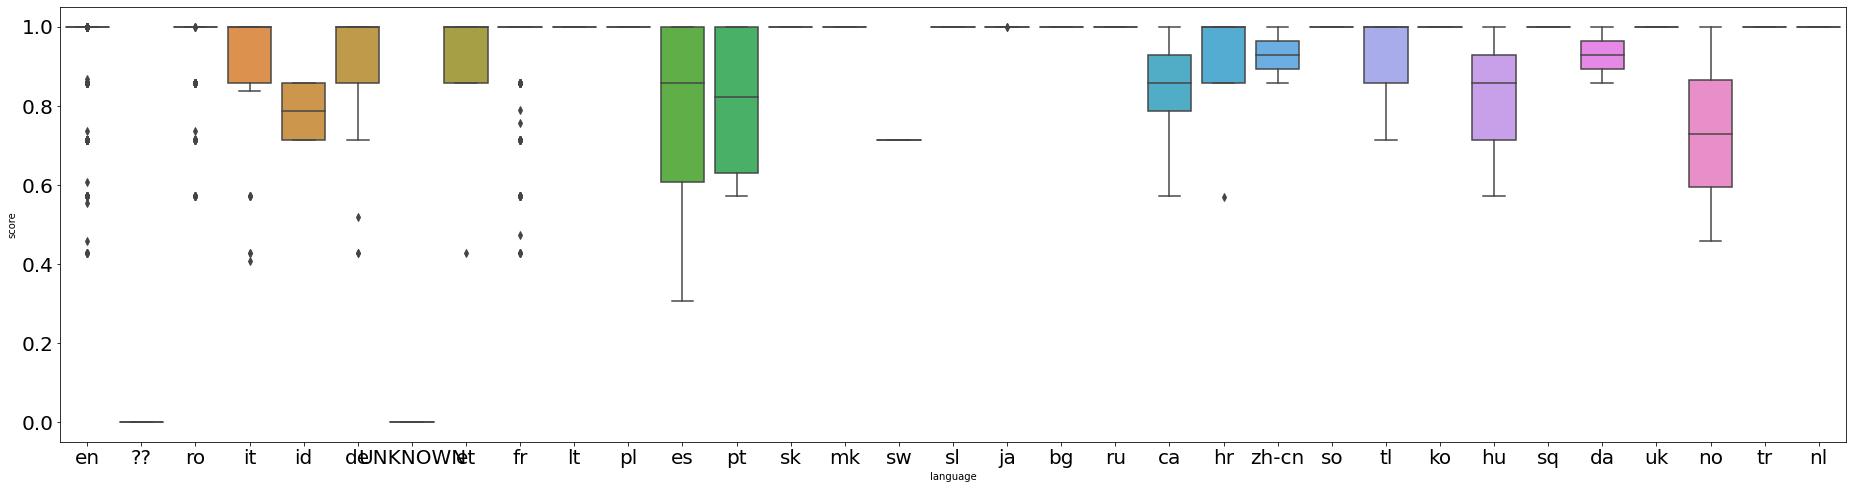

In [17]:
fig = plt.figure(figsize=(32,8))
ax = sns.boxplot(x='language', y='score', data=lang_detects_split)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.show()

In [18]:
g = lang_detects_split.groupby('language')
g.count()

,score
language,
??,39825
UNKNOWN,15
bg,1
ca,7
da,2
de,39
en,39186
es,26
et,8


In [24]:
df['language'] = lang_detects_split['language']
df['lang_score'] = lang_detects_split['score']
df

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,file_link_shown,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,0.0,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,1.0,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,0.0,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,0.0,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,0.0,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80695,142963,Laser Marking of PLA FDM Printed Products,"<jats:p>\nThe paper aimed to reveal, qualitati...",6.0,journal-article,228-238,10.37358/mp.20.2.5369,NaN,NaN,http://dx.doi.org/10.37358/mp.20.2.5369,...,NaN,"Ionel Danut, Savu; Sorin Vasile, Savu; Nicusor...",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999998
80696,142964,Studiul și animația mecanismelor aplicate -apl...,NaN,5.0,book,439,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,Printech %%439%%2020-12-15,NaN,NaN,NaN,NaN,??,0.000000
80697,142965,Mecanisme – teorie și aplicații,NaN,5.0,book,76,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,Printech %%76%%2013-08-01,NaN,NaN,NaN,NaN,??,0.000000
80698,142966,Mecanică și Mecanisme – Noțiuni teoretice si a...,NaN,5.0,book,147,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,Printech %%147%%2013-09-01,NaN,NaN,NaN,NaN,??,0.000000


In [26]:
df1 = df[df['language'] == 'en'][df['lang_score'] > 0.99]
df1

/tmp/ipykernel_552/1811985217.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df['language'] == 'en'][df['lang_score'] > 0.99]


,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,file_link_shown,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,0.0,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,1.0,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,0.0,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,0.0,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,0.0,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80689,142957,Swelling-Based Distributed Chemical Sensing wi...,<jats:p>Distributed chemical sensing is demons...,6.0,journal-article,718,10.3390/s21030718,NaN,NaN,http://dx.doi.org/10.3390/s21030718,...,NaN,"Sina, Sedighi; Marcelo A., Soto; Alin, Jderu; ...",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997
80690,142958,"Gold nanowire networks: synthesis, characteriz...",Gold nanowire networks (AuNWNs) with average w...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999
80691,142959,Phase Equilibria for Carbon Capture and Storage,Carbon dioxide (CO2) is an important material ...,2.0,book-chapter,"18,1-18",10.5772/intechopen.95136,NaN,74349.pdf,https://www.intechopen.com/online-first/phase-...,...,0.0,NaN,0.0,"Carbon Capture%%18,1-18%%IntechOpen%%2020-12-08",NaN,NaN,NaN,NaN,en,0.999998
80693,142961,THE ANALYSIS OF THE THREE-PHASE INDUCTION MOTO...,<jats:p>The three-phase induction machine math...,3.0,journal-article,1-11,10.36801/apme.2020.1.15,NaN,NaN,http://dx.doi.org/10.36801/apme.2020.1.15,...,NaN,"Mihai, Iordache; Sorin, Deleanu; Neculai, Galan",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999995


In [28]:
df1.to_hdf('df1.hdf', key='df', mode='w')

/tmp/ipykernel_552/400444818.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['title', 'abstract_text', 'publication_type', 'no_pages', 'd_oi',
       'category', 'file_link', 'external_link', 'publisher', 'w_os',
       'jhi_type', 'keywords', 'publication_date', 'authors', 'metadata',
       'internal_link', 'photo_link', 'language'],
      dtype='object')]

  df1.to_hdf('df1.hdf', key='df', mode='w')


In [30]:
# English only articles
df1 = pd.read_hdf('df1.hdf', 'df')

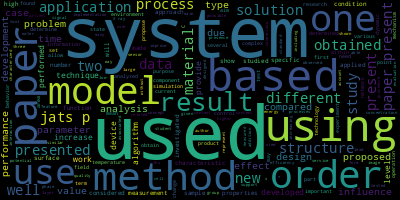

In [32]:
import wordcloud

long_string = " ".join(df1['abstract_text'])

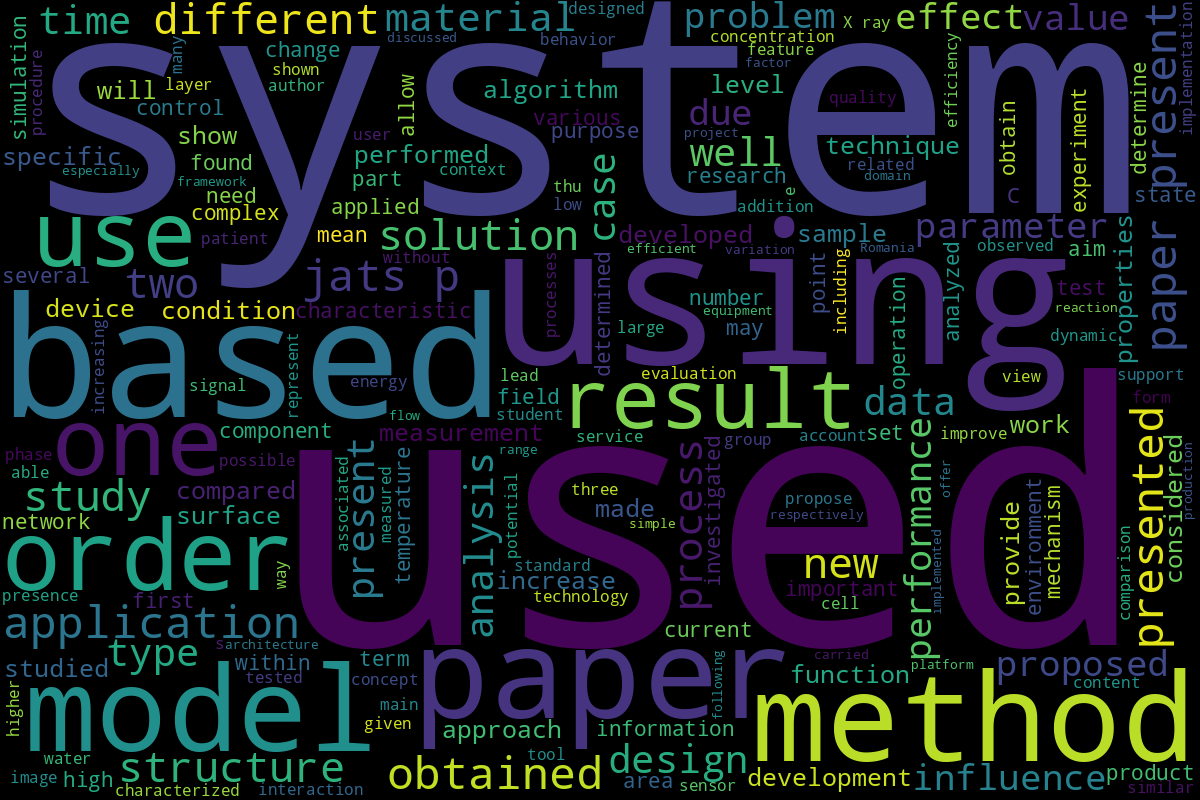

In [33]:
wc = wordcloud.WordCloud(width=1200, height=800)
wc.generate(long_string)
wc.to_image()

In [54]:
res = {i : long_string.count(i) for i in set(long_string)}

In [55]:
marklist = sorted(res.items(), key=lambda x:-x[1])
sortdict = dict(marklist)
sortdict

{' ': 4832854,
 'e': 3285820,
 't': 2341314,
 'i': 2136075,
 'a': 2089582,
 'o': 1958096,
 'n': 1926726,
 's': 1768762,
 'r': 1707230,
 'l': 1073338,
 'c': 1071699,
 'h': 973902,
 'd': 967992,
 'm': 739288,
 'p': 715798,
 'u': 683504,
 'f': 599116,
 'g': 480456,
 'y': 373206,
 'b': 327617,
 'w': 279383,
 'v': 279154,
 '.': 237594,
 ',': 210980,
 'T': 125437,
 '-': 117917,
 'x': 79201,
 'k': 72404,
 ')': 68522,
 '(': 68173,
 'A': 58149,
 'S': 54608,
 'C': 54473,
 'I': 53161,
 '0': 52247,
 'z': 46019,
 '1': 41980,
 'q': 41795,
 '2': 40254,
 'M': 39742,
 'P': 39133,
 'E': 36619,
 'R': 29675,
 'D': 28686,
 'O': 27275,
 'F': 26333,
 'N': 25763,
 'j': 25388,
 '3': 23298,
 '/': 22838,
 'B': 22699,
 'L': 22542,
 ':': 22226,
 'H': 20998,
 '5': 19757,
 'W': 17523,
 '4': 16070,
 'G': 15499,
 'V': 14416,
 '6': 12147,
 '<': 12121,
 '>': 11802,
 'U': 11248,
 '9': 11038,
 '8': 10267,
 '7': 9706,
 '?': 8855,
 '%': 7632,
 "'": 6486,
 ';': 6188,
 '\xa0': 5985,
 'K': 5739,
 '=': 5442,
 '+': 5436,
 'X': 5

In [42]:
for i in range(ord('0'), ord('9') + 1):
    del(sortdict[chr(i)])

In [63]:
x = ''.join(list(sortdict.keys()))
x

' etiaonsrlchdmpufgybwv.,T-xk)(ASCI0z1q2MPERDOFNj3/BL:H5W4GV6<>U987?%\';\xa0K=+X][…\nZ"–JQ’\\Y”`“&*−‐°μ{_}α\u2009�β@$±—×~‘γé·µ•\tă|ε\u202f^∞′©ö®ﬁδиşλ→„#στω!÷äüº§θоΩае∼Δ\u2005н≥ρţφâνπĂ≤²\uf02d■ᴵсη⋅ξлрîтóχ∈\u200b€˙ș˰ψè™∗ɛ▪țвØ∆áΓ\uf0b4¬дíм₂κ₃∇ц●ℓ⁻‒∘\u200aÅϵϕ➢àζ̅хкп»ыã¹\u2002◦у³ıΣçﬂ∎₄¯⊂б\xadñ\uf8ff\uf0b0οÉ✓й≈¿\uf06d∙″яΦзïôŞь○‟𝐼ﬀТ❑ƍ½≅Мú𝜔«īΠ𝑤ē⊣˘𝑘⋆ΩÎ\x0cГΨ⊗‰Ș⋯‚℃ÖÄř\uf0d7О正𝐾āłг₀\uf765ńœℜ∂₁\x04↔\u2006åß―ΛſщĠȚ\x96̊П∪š\x0eС̇►ˆ̄žìι𝑧ćﬃ\U0010016e∑⁺\uf073¢⁰чфК¡𝑥ₙ\uf773〈≫⊤\x03소ς\x92ū〉\uf76d𝑦\uf077ϑė⩽˜ˑℋ\u2008ɣ\x0bÂŢŃ¥ℝ⊕И‖Ü₈ℂč║⊆←Í√ÇР\uf0b1¾Š\uf026æõ£≃đ\uf05b▿\ufeffюА一❖⎠\uf775Τ∅ڂ↑ₐЩ∥Зð¸⊥\ue700⇒\uf097˹\x06\uf02b‾Ъ\x01ъЖ№þ˸②¨①⎝Àꞌ\x05˻Л⎛¼Вộ\x02ğН─⎞\U0010016d⁎△ℎÑ\uf05d٠†ж≠ê↦ڇ③ڌÁڗϹ∫ë⩾Ôø'

In [64]:
unidecode(x)

' etiaonsrlchdmpufgybwv.,T-xk)(ASCI0z1q2MPERDOFNj3/BL:H5W4GV6<>U987?%\'; K=+X][...\nZ"-JQ\'\\Y"`"&*--degm{_}a b@$+---x~\'ge*u*\ta|e ^\'(c)o(r)fidisl-,,#sto!/auoSSthoOae~D n>=rtphanpA<=2#Isexlritokh EUR.spse(tm)*e#tvOaG!dim2k3ts*l-- Aphazkhkp>>ya1 *u3iScfl4-bnoEi?\'\'iaPhzioS\'*"IffTd 1/2 Mu<<iPweVkI\x0cGPs%0S,OArOZheng Kalg0noeR1\x04- ass--LsshchGTPs\x0eS>^ziizcffi+C/0chfK!xn<\x03sosu> ythe~.H g\x0bATNY=RI||U8Cc|-ICR 3/4 SaeoPSdViuAYi TH|aShchZd,=\x06-\'\x01\'ZhNo. th2"1A\x05L 1/4 Vo\x02gN-*^hN0+zhe-cch3dhAReOo'

In [45]:
texts = df1['abstract_text']
texts

0        Cities are areas where Big Data is having a re...
1        The MonALISA (Monitoring Agents in A Large Int...
2        Introduction Data-intensive computing is now s...
3        The MonALISA (Monitoring Agents in a Large Int...
4        With Cloud Computing emerging as a promising n...
                               ...                        
80689    <jats:p>Distributed chemical sensing is demons...
80690    Gold nanowire networks (AuNWNs) with average w...
80691    Carbon dioxide (CO2) is an important material ...
80693    <jats:p>The three-phase induction machine math...
80695    <jats:p>\nThe paper aimed to reveal, qualitati...
Name: abstract_text, Length: 39053, dtype: object

In [48]:
from unidecode import unidecode
long_string_decoded = unidecode(long_string)

In [49]:
res = {i: long_string_decoded.count(i) for i in set(long_string_decoded)}
marklist = sorted(res.items(), key=lambda x: -x[1])
sortdict = dict(marklist)
sortdict

{' ': 4839379,
 'e': 3286792,
 't': 2341530,
 'i': 2136305,
 'a': 2090239,
 'o': 1958366,
 'n': 1926817,
 's': 1768988,
 'r': 1707372,
 'l': 1073453,
 'c': 1071801,
 'h': 974058,
 'd': 968664,
 'm': 739890,
 'p': 715912,
 'u': 683727,
 'f': 599218,
 'g': 481230,
 'y': 373218,
 'b': 327914,
 'w': 279389,
 'v': 279171,
 '.': 252197,
 ',': 211105,
 'T': 125449,
 '-': 122970,
 'x': 79450,
 'k': 72466,
 ')': 68699,
 '(': 68350,
 'A': 58205,
 'S': 54725,
 'C': 54477,
 'I': 53203,
 '0': 52257,
 'z': 46042,
 '1': 42001,
 'q': 41795,
 '2': 40309,
 'M': 39748,
 'P': 39154,
 'E': 36646,
 'R': 29702,
 'D': 28728,
 'O': 27346,
 'F': 26333,
 'N': 25768,
 'j': 25388,
 '3': 23323,
 '/': 22898,
 'B': 22699,
 'L': 22546,
 ':': 22226,
 'H': 21001,
 '5': 19757,
 'W': 17523,
 '4': 16080,
 'G': 15522,
 'V': 14423,
 '<': 12170,
 '6': 12147,
 '>': 11866,
 'U': 11270,
 '9': 11038,
 '8': 10269,
 '7': 9706,
 "'": 9345,
 '?': 8862,
 '%': 7636,
 ';': 6188,
 'K': 5745,
 '+': 5711,
 '=': 5519,
 '"': 5436,
 'X': 5059

In [50]:
len(sortdict)

106

In [66]:
import string

newdict = {}
for k in sortdict:
    if k in string.printable and k not in '\x0b\x0c':
        newdict[k] = sortdict[k]
print(len(newdict))
newdict

97


{' ': 4832854,
 'e': 3285820,
 't': 2341314,
 'i': 2136075,
 'a': 2089582,
 'o': 1958096,
 'n': 1926726,
 's': 1768762,
 'r': 1707230,
 'l': 1073338,
 'c': 1071699,
 'h': 973902,
 'd': 967992,
 'm': 739288,
 'p': 715798,
 'u': 683504,
 'f': 599116,
 'g': 480456,
 'y': 373206,
 'b': 327617,
 'w': 279383,
 'v': 279154,
 '.': 237594,
 ',': 210980,
 'T': 125437,
 '-': 117917,
 'x': 79201,
 'k': 72404,
 ')': 68522,
 '(': 68173,
 'A': 58149,
 'S': 54608,
 'C': 54473,
 'I': 53161,
 '0': 52247,
 'z': 46019,
 '1': 41980,
 'q': 41795,
 '2': 40254,
 'M': 39742,
 'P': 39133,
 'E': 36619,
 'R': 29675,
 'D': 28686,
 'O': 27275,
 'F': 26333,
 'N': 25763,
 'j': 25388,
 '3': 23298,
 '/': 22838,
 'B': 22699,
 'L': 22542,
 ':': 22226,
 'H': 20998,
 '5': 19757,
 'W': 17523,
 '4': 16070,
 'G': 15499,
 'V': 14416,
 '6': 12147,
 '<': 12121,
 '>': 11802,
 'U': 11248,
 '9': 11038,
 '8': 10267,
 '7': 9706,
 '?': 8855,
 '%': 7632,
 "'": 6486,
 ';': 6188,
 'K': 5739,
 '=': 5442,
 '+': 5436,
 'X': 5059,
 ']': 4967

In [78]:
reject = '\x00\x01\x02\x03\x04\x05\x06\x07\x08\x09\x0a\x0b\x0c\x0d\x0e\x0f'
new_col = df1['abstract_text'].progress_apply(lambda x : unidecode(x).replace(reject, ''))
new_col

  0%|          | 0/39053 [00:00<?, ?it/s]

0        Cities are areas where Big Data is having a re...
1        The MonALISA (Monitoring Agents in A Large Int...
2        Introduction Data-intensive computing is now s...
3        The MonALISA (Monitoring Agents in a Large Int...
4        With Cloud Computing emerging as a promising n...
                               ...                        
80689    <jats:p>Distributed chemical sensing is demons...
80690    Gold nanowire networks (AuNWNs) with average w...
80691    Carbon dioxide (CO2) is an important material ...
80693    <jats:p>The three-phase induction machine math...
80695    <jats:p>\nThe paper aimed to reveal, qualitati...
Name: abstract_text, Length: 39053, dtype: object

In [79]:
long_string = ''.join(new_col)
res = {i: long_string.count(i) for i in set(long_string)}
marklist = sorted(res.items(), key=lambda x: -x[1])
sortdict = dict(marklist)
print(len(sortdict))
sortdict

106


{' ': 4800327,
 'e': 3286792,
 't': 2341530,
 'i': 2136305,
 'a': 2090239,
 'o': 1958366,
 'n': 1926817,
 's': 1768988,
 'r': 1707372,
 'l': 1073453,
 'c': 1071801,
 'h': 974058,
 'd': 968664,
 'm': 739890,
 'p': 715912,
 'u': 683727,
 'f': 599218,
 'g': 481230,
 'y': 373218,
 'b': 327914,
 'w': 279389,
 'v': 279171,
 '.': 252197,
 ',': 211105,
 'T': 125449,
 '-': 122970,
 'x': 79450,
 'k': 72466,
 ')': 68699,
 '(': 68350,
 'A': 58205,
 'S': 54725,
 'C': 54477,
 'I': 53203,
 '0': 52257,
 'z': 46042,
 '1': 42001,
 'q': 41795,
 '2': 40309,
 'M': 39748,
 'P': 39154,
 'E': 36646,
 'R': 29702,
 'D': 28728,
 'O': 27346,
 'F': 26333,
 'N': 25768,
 'j': 25388,
 '3': 23323,
 '/': 22898,
 'B': 22699,
 'L': 22546,
 ':': 22226,
 'H': 21001,
 '5': 19757,
 'W': 17523,
 '4': 16080,
 'G': 15522,
 'V': 14423,
 '<': 12170,
 '6': 12147,
 '>': 11866,
 'U': 11270,
 '9': 11038,
 '8': 10269,
 '7': 9706,
 "'": 9345,
 '?': 8862,
 '%': 7636,
 ';': 6188,
 'K': 5745,
 '+': 5711,
 '=': 5519,
 '"': 5436,
 'X': 5059

In [80]:
df2 = df1.copy()
df2

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,file_link_shown,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,0.0,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,1.0,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,0.0,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,0.0,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,0.0,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80689,142957,Swelling-Based Distributed Chemical Sensing wi...,<jats:p>Distributed chemical sensing is demons...,6.0,journal-article,718,10.3390/s21030718,NaN,NaN,http://dx.doi.org/10.3390/s21030718,...,NaN,"Sina, Sedighi; Marcelo A., Soto; Alin, Jderu; ...",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997
80690,142958,"Gold nanowire networks: synthesis, characteriz...",Gold nanowire networks (AuNWNs) with average w...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999
80691,142959,Phase Equilibria for Carbon Capture and Storage,Carbon dioxide (CO2) is an important material ...,2.0,book-chapter,"18,1-18",10.5772/intechopen.95136,NaN,74349.pdf,https://www.intechopen.com/online-first/phase-...,...,0.0,NaN,0.0,"Carbon Capture%%18,1-18%%IntechOpen%%2020-12-08",NaN,NaN,NaN,NaN,en,0.999998
80693,142961,THE ANALYSIS OF THE THREE-PHASE INDUCTION MOTO...,<jats:p>The three-phase induction machine math...,3.0,journal-article,1-11,10.36801/apme.2020.1.15,NaN,NaN,http://dx.doi.org/10.36801/apme.2020.1.15,...,NaN,"Mihai, Iordache; Sorin, Deleanu; Neculai, Galan",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999995


In [81]:
df2.to_hdf('df2.hdf', key='df', mode='w')

/tmp/ipykernel_552/3654029758.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['title', 'abstract_text', 'publication_type', 'no_pages', 'd_oi',
       'category', 'file_link', 'external_link', 'publisher', 'w_os',
       'jhi_type', 'keywords', 'publication_date', 'authors', 'metadata',
       'internal_link', 'photo_link', 'language'],
      dtype='object')]

  df2.to_hdf('df2.hdf', key='df', mode='w')


In [2]:
df2 = pd.read_hdf('df2.hdf', 'df')
df2

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,file_link_shown,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,0.0,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,1.0,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,0.0,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,0.0,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,0.0,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80689,142957,Swelling-Based Distributed Chemical Sensing wi...,<jats:p>Distributed chemical sensing is demons...,6.0,journal-article,718,10.3390/s21030718,NaN,NaN,http://dx.doi.org/10.3390/s21030718,...,NaN,"Sina, Sedighi; Marcelo A., Soto; Alin, Jderu; ...",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997
80690,142958,"Gold nanowire networks: synthesis, characteriz...",Gold nanowire networks (AuNWNs) with average w...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999
80691,142959,Phase Equilibria for Carbon Capture and Storage,Carbon dioxide (CO2) is an important material ...,2.0,book-chapter,"18,1-18",10.5772/intechopen.95136,NaN,74349.pdf,https://www.intechopen.com/online-first/phase-...,...,0.0,NaN,0.0,"Carbon Capture%%18,1-18%%IntechOpen%%2020-12-08",NaN,NaN,NaN,NaN,en,0.999998
80693,142961,THE ANALYSIS OF THE THREE-PHASE INDUCTION MOTO...,<jats:p>The three-phase induction machine math...,3.0,journal-article,1-11,10.36801/apme.2020.1.15,NaN,NaN,http://dx.doi.org/10.36801/apme.2020.1.15,...,NaN,"Mihai, Iordache; Sorin, Deleanu; Neculai, Galan",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999995


In [6]:
df2

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,file_link_shown,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,0.0,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,1.0,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,0.0,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,0.0,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,0.0,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80689,142957,Swelling-Based Distributed Chemical Sensing wi...,<jats:p>Distributed chemical sensing is demons...,6.0,journal-article,718,10.3390/s21030718,NaN,NaN,http://dx.doi.org/10.3390/s21030718,...,NaN,"Sina, Sedighi; Marcelo A., Soto; Alin, Jderu; ...",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997
80690,142958,"Gold nanowire networks: synthesis, characteriz...",Gold nanowire networks (AuNWNs) with average w...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999
80691,142959,Phase Equilibria for Carbon Capture and Storage,Carbon dioxide (CO2) is an important material ...,2.0,book-chapter,"18,1-18",10.5772/intechopen.95136,NaN,74349.pdf,https://www.intechopen.com/online-first/phase-...,...,0.0,NaN,0.0,"Carbon Capture%%18,1-18%%IntechOpen%%2020-12-08",NaN,NaN,NaN,NaN,en,0.999998
80693,142961,THE ANALYSIS OF THE THREE-PHASE INDUCTION MOTO...,<jats:p>The three-phase induction machine math...,3.0,journal-article,1-11,10.36801/apme.2020.1.15,NaN,NaN,http://dx.doi.org/10.36801/apme.2020.1.15,...,NaN,"Mihai, Iordache; Sorin, Deleanu; Neculai, Galan",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999995


In [8]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

cleanr = re.compile(r'</?[a-z]+(:.+)?>|<([\w-]*|)>')

# reject = '\x00\x01\x02\x03\x04\x05\x06\x07\x08\x09\x0a\x0b\x0c\x0d\x0e\x0f'
# new_col = df1['abstract_text'].progress_apply(lambda x : unidecode(x).replace(reject, ''))

def preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()

    sentence=sentence.replace('{html}',"")
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    # TODO: Remove numbers in word form like 'three', 'fourth'
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(lemma_words)


df3 = df2.copy()
df3['abstract_text_clean'] = df2['abstract_text'].progress_map(lambda s:preprocess(s))
df3

  0%|          | 0/39053 [00:00<?, ?it/s]

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,file_link_shown,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score
0,1,Intelligent services for Big Data science,citi area big data real impact town planner ad...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,0.0,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997
1,2,"MonALISA: An agent based, dynamic service syst...",monalisa monitor agent larg integr servic arch...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,1.0,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996
2,3,Big data and internet of things: a roadmap for...,introduct data intens comput start consid basi...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,0.0,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998
3,4,"MonALISA: An agent based, dynamic service syst...",monalisa monitor agent larg integr servic arch...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,0.0,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998
4,5,Parallel Programming Paradigms and Frameworks ...,cloud comput emerg promis new approach hoc par...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,0.0,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80689,142957,Swelling-Based Distributed Chemical Sensing wi...,,6.0,journal-article,718,10.3390/s21030718,NaN,NaN,http://dx.doi.org/10.3390/s21030718,...,NaN,"Sina, Sedighi; Marcelo A., Soto; Alin, Jderu; ...",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997
80690,142958,"Gold nanowire networks: synthesis, characteriz...",gold nanowir network aunwn averag width aunwn ...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999
80691,142959,Phase Equilibria for Carbon Capture and Storage,carbon dioxid import materi mani industri also...,2.0,book-chapter,"18,1-18",10.5772/intechopen.95136,NaN,74349.pdf,https://www.intechopen.com/online-first/phase-...,...,0.0,NaN,0.0,"Carbon Capture%%18,1-18%%IntechOpen%%2020-12-08",NaN,NaN,NaN,NaN,en,0.999998
80693,142961,THE ANALYSIS OF THE THREE-PHASE INDUCTION MOTO...,,3.0,journal-article,1-11,10.36801/apme.2020.1.15,NaN,NaN,http://dx.doi.org/10.36801/apme.2020.1.15,...,NaN,"Mihai, Iordache; Sorin, Deleanu; Neculai, Galan",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999995


In [103]:
cleanr = re.compile(r'<.*?>')
jatsr = re.compile(r'</?[a-z]+(:.+)?>|<([\w-]*|)>')

def find_lege(sentence):
    sentence=str(sentence)
    cleantext = re.sub(jatsr, '', sentence)
    res = re.findall(cleanr, cleantext)
    if len(res) > 0:
        print(sentence + '   \n' + str(res) + '\n\n')
    return sentence

df2['abstract_text'].progress_map(lambda s:find_lege(s))

  0%|          | 0/39053 [00:00<?, ?it/s]

This paper presents the results obtained in monitoring potassium, calcium, and magnesium ions content in Chorella homosphaera 424 culture media using in-house manufactured potassium, calcium and magnesium ion selective electrodes. The sensors were prepared with poly (vinyl chloride) plasticized with o-nitrophenyl octyl ether. Valinomycin (I), N, N, N’, N’-tetra [cyclohexyl] diglycolic acid diamine, and bis-N, N-dicyclohexylmalonamide were chosen as ionophores. The membranes worked well in the 10-4-10-1 mol/L concentration range, displaying Nernstian slopes of 57.0±1.0, 27.0±1.0, and 27.0±0.5 mV per decade of K+, Ca2+, and Mg2+ ions activity. The electrodes responses showed pH dependence at pH< 4.0 and at pH> 11.0. The selectivity coefficients, measured by the mixed solutions method, ranged from 1.0. 10-1 to 3.2. 10-9. The newly prepared sensors gave good results in monitoring potassium, calcium, and magnesium levels in Chlorella homosphaera 424 culture media, as cross-checked by AAS.  

0        Cities are areas where Big Data is having a re...
1        The MonALISA (Monitoring Agents in A Large Int...
2        Introduction Data-intensive computing is now s...
3        The MonALISA (Monitoring Agents in a Large Int...
4        With Cloud Computing emerging as a promising n...
                               ...                        
80689    <jats:p>Distributed chemical sensing is demons...
80690    Gold nanowire networks (AuNWNs) with average w...
80691    Carbon dioxide (CO2) is an important material ...
80693    <jats:p>The three-phase induction machine math...
80695    <jats:p>\nThe paper aimed to reveal, qualitati...
Name: abstract_text, Length: 39053, dtype: object

In [57]:
df3 = df3[df3['abstract_text_clean'] != '']

In [80]:
df3[df3['abstract_text_clean'].duplicated() == False]

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score,abstract_text_clean
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997,citi area big data real impact town planner ad...
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996,monalisa monitor agent larg integr servic arch...
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998,introduct data intens comput start consid basi...
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998,monalisa monitor agent larg integr servic arch...
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998,cloud comput emerg promis new approach hoc par...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80652,142920,Non-Newtonian fluids mixing time in spherical ...,This paper describes an experimental study reg...,3.0,journal-article,1014-1016,NaN,NaN,NaN,NaN,...,"Muntean, O; Jinescu, CV; Taca, C",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997,paper describ experiment studi regard non newt...
80660,142928,ANALYSIS OF THE POSSIBILITIES OF TRANSFORMATIO...,The theme of this article aims to solve a very...,3.0,journal-article,261-270,NaN,NaN,NaN,NaN,...,NaN,0.0,"Scientific Bulletin - ""Politehnica"" University...",NaN,NaN,NaN,NaN,en,0.999997,theme articl aim solv import problem industri ...
80690,142958,"Gold nanowire networks: synthesis, characteriz...",Gold nanowire networks (AuNWNs) with average w...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,...,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999,gold nanowir network aunwn averag width aunwn ...
80691,142959,Phase Equilibria for Carbon Capture and Storage,Carbon dioxide (CO2) is an important material ...,2.0,book-chapter,"18,1-18",10.5772/intechopen.95136,NaN,74349.pdf,https://www.intechopen.com/online-first/phase-...,...,NaN,0.0,"Carbon Capture%%18,1-18%%IntechOpen%%2020-12-08",NaN,NaN,NaN,NaN,en,0.999998,carbon dioxid import materi mani industri also...


In [81]:
df3.to_hdf('df3.hdf', key='df', mode='w')

/tmp/ipykernel_2415/29241761.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['title', 'abstract_text', 'publication_type', 'no_pages', 'd_oi',
       'category', 'file_link', 'external_link', 'publisher', 'w_os',
       'jhi_type', 'keywords', 'publication_date', 'authors', 'metadata',
       'internal_link', 'photo_link', 'language', 'abstract_text_clean'],
      dtype='object')]

  df3.to_hdf('df3.hdf', key='df', mode='w')


In [5]:
df3 = pd.read_hdf('df3.hdf', 'df')
df3

,id,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,...,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score,abstract_text_clean
0,1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,...,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997,citi area big data real impact town planner ad...
1,2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,...,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996,monalisa monitor agent larg integr servic arch...
2,3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,...,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998,introduct data intens comput start consid basi...
3,4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,...,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998,monalisa monitor agent larg integr servic arch...
4,5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,...,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998,cloud comput emerg promis new approach hoc par...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80652,142920,Non-Newtonian fluids mixing time in spherical ...,This paper describes an experimental study reg...,3.0,journal-article,1014-1016,NaN,NaN,NaN,NaN,...,"Muntean, O; Jinescu, CV; Taca, C",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997,paper describ experiment studi regard non newt...
80660,142928,ANALYSIS OF THE POSSIBILITIES OF TRANSFORMATIO...,The theme of this article aims to solve a very...,3.0,journal-article,261-270,NaN,NaN,NaN,NaN,...,NaN,0.0,"Scientific Bulletin - ""Politehnica"" University...",NaN,NaN,NaN,NaN,en,0.999997,theme articl aim solv import problem industri ...
80690,142958,"Gold nanowire networks: synthesis, characteriz...",Gold nanowire networks (AuNWNs) with average w...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,...,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999,gold nanowir network aunwn averag width aunwn ...
80691,142959,Phase Equilibria for Carbon Capture and Storage,Carbon dioxide (CO2) is an important material ...,2.0,book-chapter,"18,1-18",10.5772/intechopen.95136,NaN,74349.pdf,https://www.intechopen.com/online-first/phase-...,...,NaN,0.0,"Carbon Capture%%18,1-18%%IntechOpen%%2020-12-08",NaN,NaN,NaN,NaN,en,0.999998,carbon dioxid import materi mani industri also...


In [16]:
all_str = {}
def acc(text):
    global all_str
    parts = text.split(' ')
    for p in parts:
        all_str[p] = all_str.get(p, 0) + 1

df3['abstract_text_clean'].progress_apply(acc)
all_str

  0%|          | 0/37137 [00:00<?, ?it/s]

{'citi': 622,
 'area': 3504,
 'big': 466,
 'data': 10483,
 'real': 2834,
 'impact': 1806,
 'town': 45,
 'planner': 21,
 'administr': 381,
 'bodi': 1360,
 'need': 3122,
 'right': 1177,
 'tool': 2744,
 'fingertip': 7,
 'consum': 932,
 'point': 3741,
 'gener': 7941,
 'abl': 1376,
 'turn': 466,
 'action': 1032,
 'improv': 5200,
 'peopl': 1013,
 'live': 666,
 'case': 5230,
 'definit': 397,
 'phenomenon': 1250,
 'direct': 2552,
 'qualiti': 3628,
 'life': 1260,
 'choos': 442,
 'smart': 1181,
 'tomorrow': 10,
 'reli': 583,
 'sensor': 2896,
 'within': 2528,
 'infrastructur': 902,
 'also': 8063,
 'larg': 3449,
 'number': 3671,
 'devic': 4422,
 'willingli': 2,
 'sen': 916,
 'integr': 4065,
 'technolog': 5906,
 'platform': 1942,
 'use': 36431,
 'introspect': 5,
 'habit': 42,
 'situat': 1051,
 'individu': 1006,
 'commun': 3228,
 'predict': 2228,
 'say': 80,
 'terabyt': 13,
 'per': 506,
 'day': 1014,
 'squar': 651,
 'kilomet': 16,
 'urban': 563,
 'land': 351,
 'handl': 534,
 'effici': 5479,
 'amount

In [17]:
def make_sorted_map(m):
    marklist = sorted(m.items(), key=lambda x: -x[1])
    sortdict = dict(marklist)
    return sortdict

In [22]:
token_to_count_df3 = make_sorted_map(all_str)
token_to_count_df3

{'use': 36431,
 'system': 21246,
 'paper': 21069,
 'present': 19043,
 'model': 15971,
 'result': 15163,
 'process': 14393,
 'base': 14143,
 'method': 13899,
 'studi': 13055,
 'obtain': 10697,
 'data': 10483,
 'perform': 10225,
 'differ': 9975,
 'develop': 9739,
 'time': 9390,
 'control': 9325,
 'two': 8814,
 'order': 8638,
 'new': 8516,
 'propos': 8359,
 'applic': 8319,
 'one': 8288,
 'structur': 8277,
 'solut': 8199,
 'analysi': 8190,
 'measur': 8148,
 'energi': 8107,
 'also': 8063,
 'gener': 7941,
 'high': 7891,
 'design': 7659,
 'materi': 7538,
 'power': 6732,
 'function': 6647,
 'effect': 6562,
 'increas': 6512,
 'network': 6403,
 'simul': 6265,
 'determin': 6260,
 'comput': 6158,
 'test': 6153,
 'paramet': 6080,
 'product': 6015,
 'technolog': 5906,
 'experiment': 5904,
 'algorithm': 5897,
 'type': 5819,
 'provid': 5676,
 'properti': 5668,
 'work': 5633,
 'mechan': 5595,
 'oper': 5585,
 'approach': 5582,
 'show': 5527,
 'field': 5503,
 'effici': 5479,
 'research': 5477,
 'investig

In [26]:
tokens_sorted_by_count = list(token_to_count_df3.keys())
tokens_sorted_by_count

['use',
 'system',
 'paper',
 'present',
 'model',
 'result',
 'process',
 'base',
 'method',
 'studi',
 'obtain',
 'data',
 'perform',
 'differ',
 'develop',
 'time',
 'control',
 'two',
 'order',
 'new',
 'propos',
 'applic',
 'one',
 'structur',
 'solut',
 'analysi',
 'measur',
 'energi',
 'also',
 'gener',
 'high',
 'design',
 'materi',
 'power',
 'function',
 'effect',
 'increas',
 'network',
 'simul',
 'determin',
 'comput',
 'test',
 'paramet',
 'product',
 'technolog',
 'experiment',
 'algorithm',
 'type',
 'provid',
 'properti',
 'work',
 'mechan',
 'oper',
 'approach',
 'show',
 'field',
 'effici',
 'research',
 'investig',
 'problem',
 'temperatur',
 'import',
 'case',
 'valu',
 'improv',
 'activ',
 'imag',
 'level',
 'well',
 'optim',
 'techniqu',
 'compar',
 'current',
 'inform',
 'condit',
 'surfac',
 'complex',
 'implement',
 'composit',
 'state',
 'evalu',
 'distribut',
 'main',
 'devic',
 'consid',
 'requir',
 'electr',
 'phase',
 'first',
 'specif',
 'analyz',
 'elect

In [19]:
all_ap = 0
for k, v in all_str.items():
    all_ap += v
all_ap

2712789

In [20]:
p = []
s = 0
for k, v in all_str.items():
    s += v
    p.append(s / all_ap)

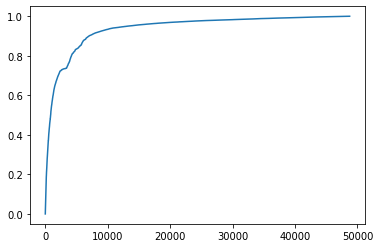

In [21]:
plt.plot(p)

In [88]:
def search_proc(array, target):
    for i in range(len(array)):
        if array[i] >= target:
            return i / len(array)
    return 1

{x:search_proc(p, x) for x in [round(x, 3) for x in np.linspace(0.25, 1, 16).tolist()]}

{0.25: 0.005414162958101761,
 0.3: 0.006890752855765878,
 0.35: 0.009044113123192716,
 0.4: 0.01132052254875823,
 0.45: 0.01410963679990156,
 0.5: 0.017390947683599597,
 0.55: 0.020897848690551876,
 0.6: 0.02565574947191403,
 0.65: 0.03158261725559361,
 0.7: 0.042513484136912694,
 0.75: 0.07313221632042001,
 0.8: 0.08582678780172678,
 0.85: 0.11462029080617707,
 0.9: 0.14380344947806648,
 0.95: 0.271610508398105,
 1.0: 0.9999794918069769}

In [3]:
c = 0
def count_empty(x):
    global c
    if len(x) == 0:
        c += 1

df3['abstract_text_clean'].progress_apply(count_empty)
c

  0%|          | 0/37137 [00:00<?, ?it/s]

0

In [6]:
class LDAConfig:
    def __init__(self):
        self.lda_num_topics = 10
        self.lda_chunksize = 5000
        self.lda_passes = 4
        self.lda_iterations = 400
        self.lda_eval_every = 1
        self.no_below = 20
        self.no_above = 0.5
        self.test_size = 0.2
        self.cv_size = 0.2

conf = LDAConfig()

In [7]:
train_cv, test = train_test_split(df3, test_size=conf.test_size, random_state=42)
test['abstract_text_clean'].describe()

count                                                  7428
unique                                                 7298
top       milk qualiti import criterion select done cons...
freq                                                     15
Name: abstract_text_clean, dtype: object

In [8]:
train, cv = train_test_split(train_cv, test_size=conf.cv_size * len(df3) / len(train_cv), shuffle=False)
train['abstract_text_clean'].describe()

count                                                 22281
unique                                                21500
top       milk qualiti import criterion select done cons...
freq                                                     47
Name: abstract_text_clean, dtype: object

In [9]:
cv['abstract_text_clean'].describe()

count                                                  7428
unique                                                 7307
top       milk qualiti import criterion select done cons...
freq                                                     11
Name: abstract_text_clean, dtype: object

In [10]:
corpus_unsplit = train['abstract_text_clean'].tolist()
corpus = [text.split(' ') for text in corpus_unsplit]
corpus

[['reduct',
  'diesel',
  'intern',
  'combust',
  'engin',
  'emiss',
  'one',
  'major',
  'concern',
  'engin',
  'manufactur',
  'despit',
  'fact',
  'effici',
  'ga',
  'post',
  'treatment',
  'system',
  'significantli',
  'improv',
  'decreas',
  'smoke',
  'soot',
  'cylind',
  'insid',
  'remain',
  'main',
  'research',
  'goal',
  'work',
  'propos',
  'theoret',
  'studi',
  'pollut',
  'format',
  'differ',
  'kind',
  'direct',
  'inject',
  'method',
  'divid',
  'cylind',
  'inject',
  'heat',
  'releas',
  'characterist',
  'could',
  'modifi',
  'lead',
  'differ',
  'temperatur',
  'pressur',
  'level',
  'use',
  'exhaust',
  'ga',
  'recircul',
  'egr',
  'reduct',
  'ga',
  'temperatur',
  'might',
  'also',
  'decreas',
  'limit',
  'nox',
  'format',
  'evalu',
  'level',
  'cylind',
  'ga',
  'emiss',
  'format',
  'two',
  'step',
  'procedur',
  'could',
  'follow',
  'first',
  'use',
  'numer',
  'calcul',
  'system',
  'heat',
  'releas',
  'characterist

In [11]:
dictionary = corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below=conf.no_below, no_above=conf.no_above)

2022-04-11 21:22:35,614 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2022-04-11 21:22:36,482 : INFO : adding document #10000 to Dictionary(25181 unique tokens: ['also', 'calcul', 'characterist', 'combust', 'concern']...)
2022-04-11 21:22:37,499 : INFO : adding document #20000 to Dictionary(35608 unique tokens: ['also', 'calcul', 'characterist', 'combust', 'concern']...)
2022-04-11 21:22:37,736 : INFO : built Dictionary(37744 unique tokens: ['also', 'calcul', 'characterist', 'combust', 'concern']...) from 22281 documents (total 1624155 corpus positions)
2022-04-11 21:22:37,737 : DEBUG : starting a new internal lifecycle event log for Dictionary
2022-04-11 21:22:37,738 : INFO : Dictionary lifecycle event {'msg': "built Dictionary(37744 unique tokens: ['also', 'calcul', 'characterist', 'combust', 'concern']...) from 22281 documents (total 1624155 corpus positions)", 'datetime': '2022-04-11T21:22:37.737717', 'gensim': '4.1.2', 'python': '3.8.10 (default, Mar 15 2022, 12:2

In [12]:
corpus_filtered = [dictionary.doc2bow(doc) for doc in corpus]
corpus_filtered

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 2),
  (5, 2),
  (6, 3),
  (7, 2),
  (8, 1),
  (9, 2),
  (10, 2),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 2),
  (15, 3),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 4),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 2),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 2),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 2),
  (50, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 2),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1)],
 [(63, 1),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 2),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 2),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 1),
  (90, 1),
  (91, 1

In [13]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 4436
Number of documents: 22281


In [14]:
lda_model = gensim.models.LdaModel(corpus=corpus_filtered,
                                   id2word=dictionary,
                                   chunksize=conf.lda_chunksize,
                                   alpha='auto',
                                   eta='auto',
                                   iterations=conf.lda_iterations,
                                   passes=conf.lda_passes,
                                   eval_every=conf.lda_eval_every,
                                   num_topics=conf.lda_num_topics)

2022-04-11 21:22:41,992 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2022-04-11 21:22:42,000 : INFO : using serial LDA version on this node
2022-04-11 21:22:42,009 : INFO : running online (multi-pass) LDA training, 10 topics, 4 passes over the supplied corpus of 22281 documents, updating model once every 5000 documents, evaluating perplexity every 5000 documents, iterating 400x with a convergence threshold of 0.001000
2022-04-11 21:22:42,033 : DEBUG : bound: at document #0
2022-04-11 21:22:55,642 : INFO : -9.021 per-word bound, 519.4 perplexity estimate based on a held-out corpus of 5000 documents with 332099 words
2022-04-11 21:22:55,644 : INFO : PROGRESS: pass 0, at document #5000/22281
2022-04-11 21:22:55,644 : DEBUG : performing inference on a chunk of 5000 documents
2022-04-11 21:23:08,481 : DEBUG : 4365/5000 documents converged within 400 iterations
2022-04-11 21:23:08,502 : INFO : optimized alpha [0.058881838, 0.06629279, 0.059

In [15]:
top_topics = lda_model.top_topics(corpus_filtered) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / conf.lda_num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint

pprint(top_topics)

2022-04-11 21:25:21,031 : DEBUG : Setting topics to those of the model: LdaModel(num_terms=4436, num_topics=10, decay=0.5, chunksize=5000)
2022-04-11 21:25:21,051 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2022-04-11 21:25:21,070 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2022-04-11 21:25:21,084 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2022-04-11 21:25:21,100 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2022-04-11 21:25:21,118 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2022-04-11 21:25:21,134 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2022-04-11 21:25:21,150 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2022-04-11 21:25:21,165 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2022-04-11 21:25:21,183 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2022-04-11 21:25:21,210 : INFO : CorpusAccumulator accumulat

Average topic coherence: -1.8830.
[([(0.01582387, 'method'),
   (0.014243963, 'algorithm'),
   (0.011675914, 'problem'),
   (0.010498539, 'paper'),
   (0.010417943, 'result'),
   (0.008714649, 'propos'),
   (0.008610213, 'base'),
   (0.008380978, 'model'),
   (0.0070400895, 'gener'),
   (0.006723229, 'approach'),
   (0.006420393, 'two'),
   (0.006226648, 'present'),
   (0.0061766277, 'function'),
   (0.0058628633, 'comput'),
   (0.005686702, 'set'),
   (0.005646378, 'data'),
   (0.0054761134, 'order'),
   (0.005429083, 'time'),
   (0.0054076803, 'perform'),
   (0.0052248426, 'system')],
  -1.513671718701249),
 ([(0.01815597, 'materi'),
   (0.013791358, 'composit'),
   (0.01230265, 'properti'),
   (0.011128572, 'obtain'),
   (0.0103624435, 'structur'),
   (0.009928397, 'alloy'),
   (0.0094458815, 'surfac'),
   (0.008820236, 'film'),
   (0.0073185824, 'sampl'),
   (0.0070472066, 'process'),
   (0.007004171, 'studi'),
   (0.0068698656, 'mechan'),
   (0.0068156477, 'temperatur'),
   (0.006

In [16]:
df3['authors']

0                                     C., Dobre; F., Xhafa
1        Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...
2                                 Bessis Nik,Dobre Ciprian
3        I., Legrand; H., Newman; R., Voicu; C., Cirsto...
4                             Ciprian, Dobre; Fatos, Xhafa
                               ...                        
80652                     Muntean, O; Jinescu, CV; Taca, C
80660                                                  NaN
80690                                                  NaN
80691                                                  NaN
80695    Ionel Danut, Savu; Sorin Vasile, Savu; Nicusor...
Name: authors, Length: 37137, dtype: object

In [178]:
full_name_reg = re.compile(r'[a-zA-Z][a-zA-Z]{2,}|[a-z]') # Dont allow 'A' 'AA', but allow 'So' or 3 or more letter words
def get_full_name(name):
    names = full_name_reg.findall(name)
    if len(names) >= 2: # must have at least 2 names
        return names
    return None

name_reg = re.compile(r'[a-zA-Z]+')
def get_shortened_name(name):
    names = name_reg.findall(name)
    if len(names) >= 2:
        result = []
        for n in names:
            if len(n) == 2 and n.isupper():
                result.append(n[0])
                result.append(n[1])
            else:
                result.append(n)
        return result
    return None

NAME_INVALID = "INVALID"
NAME_FULL = "FULL_NAME"
NAME_SHORT = "SHORT_NAME"

class Name:
    def __init__(self, name_raw):
        self.names = get_full_name(name_raw)
        if self.names is not None:
            self.type = NAME_FULL
        else:
            self.type = NAME_SHORT
            self.names = get_shortened_name(name_raw)
            if self.names is None:
                self.type = NAME_INVALID
        if self.names is not None:
            self.lower_names = [n.lower() for n in self.names]

    def __str__(self):
        return self.names.__str__()

    def __repr__(self):
        return self.names.__str__()

def has_initial(name:str, names:set):
    for initial in names:
        if len(initial) == 1 and name[0] == initial:
            return True
    return False

def matches_full_name(a:str, b:str):
    return a == b and len(a) > 1

def match_names(a:Name, b:Name):
    a_names = a.lower_names.copy()
    b_names = b.lower_names.copy()

    match_last_name = False

    if matches_full_name(a_names[0], b_names[0]):
        a_names = a_names[1:]
        b_names = b_names[1:]
        match_last_name = True
    elif matches_full_name(a_names[0], b_names[-1]):
        a_names = a_names[1:]
        b_names = b_names[:-1]
        match_last_name = True
    elif matches_full_name(a_names[-1], b_names[0]):
        a_names = a_names[:-1]
        b_names = b_names[1:]
        match_last_name = True
    elif matches_full_name(a_names[-1], b_names[-1]):
        a_names = a_names[:-1]
        b_names = b_names[:-1]
        match_last_name = True

    if not match_last_name: # assume last name is not shortened
        return False

    a_set = set(a_names)
    b_set = set(b_names)
    if a_set == b_set or a_set.issubset(b_set) or a_set.issuperset(b_set):
        return True

    inter = a_set.intersection(b_set)
    a_set = a_set.difference(inter)
    b_set = b_set.difference(inter)

    to_remove = {}
    for name in a_set:
        if len(name) > 1:
            if has_initial(name, b_set):
                to_remove.add(name)
                b_set.remove(name[0])
    a_set = a_set.difference(to_remove)

    to_remove = {}
    for name in b_set:
        if len(name) > 1:
            if has_initial(name, a_set):
                to_remove.add(name)
                a_set.remove(name[0])
    b_set = b_set.difference(to_remove)

    return len(a_set) == 0 or len(b_set) == 0

single_author_reg = re.compile(r"[a-zA-Z .-]+,?[a-zA-Z .-]+")

def parse_authors(authors):
    orig_authors = authors
    try:
        if type(authors) != str:
            return None
        authors = unidecode(authors)
        authors = authors.strip()
        if authors.startswith(","):
            authors = authors[1:]
            authors = authors.strip()
        if authors == "" or authors == "null":
            return None
        if single_author_reg.match(authors):
            parts = [authors]
        else:
            parts = authors.split(";")
            if len(parts) == 1:
                parts = authors.split(",")
            if len(parts) == 0:
                return None, False
        result = [Name(part) for part in parts]
        types = {n.type for n in result}
        if NAME_INVALID in types:
            print("Error parsing: ", types)
            print("'", orig_authors, "'")
            print(parts)
            print(result)
            print()
        return result
    except:
        print("!! Exception on '", orig_authors, "'")
        return None

In [179]:
author_names = df3['authors'].progress_map(parse_authors)

  0%|          | 0/37137 [00:00<?, ?it/s]

Error parsing:  {'SHORT_NAME', 'INVALID'}
' ????rlea, M.-M.; Cincu, C.; Marton, G.; Tomas, ??.; Silvestro, L. '
['????rlea, M.-M.', ' Cincu, C.', ' Marton, G.', ' Tomas, ??.', ' Silvestro, L.']
[['rlea', 'M', 'M'], ['Cincu', 'C'], ['Marton', 'G'], None, ['Silvestro', 'L']]

Error parsing:  {'SHORT_NAME', 'INVALID'}
' C??rtoaje, C. '
['C??rtoaje', ' C.']
[['C', 'rtoaje'], None]

Error parsing:  {'FULL_NAME', 'INVALID', 'SHORT_NAME'}
' B??d??noiu, A.; Stoleriu, ??.; Voicu, G. '
['B??d??noiu, A.', ' Stoleriu, ??.', ' Voicu, G.']
[['d', 'noiu'], None, ['Voicu', 'G']]

Error parsing:  {'FULL_NAME', 'INVALID'}
' ??tef??noiu, R. '
['??tef??noiu', ' R.']
[['tef', 'noiu'], None]

Error parsing:  {'SHORT_NAME', 'INVALID'}
' B??lan, C. '
['B??lan', ' C.']
[['B', 'lan'], None]



In [177]:

unidecode(' Bîrsan C.,Liţescu S.C.,Vasilescu I.,Radu, G.L. ')

' Birsan C.,Litescu S.C.,Vasilescu I.,Radu, G.L. '

In [166]:
type(v)

str

In [75]:
names = df3['authors'][1]
print(names)
parse_authors(names)

Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Ciprian Mihai, DOBRE; Newman B, HARVEY; Ramiro, VOICU; Grigoras, COSTIN; Mihaela, Toarta; Harvey, NEWMAN
['Iosif Charles, LEGRAND', ' Catalin, CIRSTOIU', ' Ciprian Mihai, DOBRE', ' Newman B, HARVEY', ' Ramiro, VOICU', ' Grigoras, COSTIN', ' Mihaela, Toarta', ' Harvey, NEWMAN']


[['Iosif', 'Charles', 'LEGRAND'],
 ['Catalin', 'CIRSTOIU'],
 ['Ciprian', 'Mihai', 'DOBRE'],
 ['Newman', 'HARVEY'],
 ['Ramiro', 'VOICU'],
 ['Grigoras', 'COSTIN'],
 ['Mihaela', 'Toarta'],
 ['Harvey', 'NEWMAN']]

In [71]:
df3['authors'][2]

'Bessis Nik,Dobre Ciprian'

In [72]:
get_shortened_name("C., Dobre")

['C', 'Dobre']

In [73]:
get_full_name("Bessis Nik")

['Bessis', 'Nik']

In [74]:
re.findall(full_name_reg, "Bessis Nik")

['Bessis', 'Nik']

In [109]:
" null".strip() == "null"

True

In [21]:
df3 = df3.set_index('id')
df3

,title,abstract_text,no_coauthors,publication_type,no_pages,d_oi,category,file_link,external_link,publisher,...,authors,citations_number,metadata,internal_link,keywords_valid,photo_link,mapped_to_id,language,lang_score,abstract_text_clean
id,,,,,,,,,,,,,,,,,,,,,
1,Intelligent services for Big Data science,Cities are areas where Big Data is having a re...,2.0,journal-article,267-281,10.1016/j.future.2013.07.014,NaN,2013_21.pdf,http://dx.doi.org/10.1016/j.future.2013.07.014,Elsevier BV,...,"C., Dobre; F., Xhafa",307.0,Future Generation Computer Systems%%null%%37%%...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999997,citi area big data real impact town planner ad...
2,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in A Large Int...,8.0,proceedings-article,1--4,NaN,NaN,NaN,http://cds.cern.ch/record/865735/files/p907.pdf,CERN,...,"Iosif Charles, LEGRAND; Catalin, CIRSTOIU; Cip...",161.0,Computing in High Energy Physics %%CHEP04%%Swi...,NaN,0.0,NaN,NaN,en,0.999996,monalisa monitor agent larg integr servic arch...
3,Big data and internet of things: a roadmap for...,Introduction Data-intensive computing is now s...,3.0,book,470,10.1007/978-3-319-05029-4,NaN,3db0cd3580d92b16-Big-Data-and-Internet-of-Thin...,http://dx.doi.org/10.1007/978-3-319-05029-4,"Springer International Publishing Basel, Switz...",...,"Bessis Nik,Dobre Ciprian",205.0,"Springer International Publishing Basel, Switz...",NaN,0.0,9783319050287.jpg,NaN,en,0.999998,introduct data intens comput start consid basi...
4,"MonALISA: An agent based, dynamic service syst...",The MonALISA (Monitoring Agents in a Large Int...,10.0,journal-article,2472-2498,10.1016/j.cpc.2009.08.003,NaN,2009_2.pdf,http://dx.doi.org/10.1016/j.cpc.2009.08.003,Elsevier BV,...,"I., Legrand; H., Newman; R., Voicu; C., Cirsto...",108.0,COMPUTER PHYSICS COMMUNICATIONS%%null%%180%%12...,https://api.elsevier.com/content/article/PII:S...,0.0,NaN,NaN,en,0.999998,monalisa monitor agent larg integr servic arch...
5,Parallel Programming Paradigms and Frameworks ...,With Cloud Computing emerging as a promising n...,2.0,journal-article,710-738,10.1007/s10766-013-0272-7,NaN,2013_17.pdf,http://dx.doi.org/10.1007/s10766-013-0272-7,Springer Science and Business Media LLC,...,"Ciprian, Dobre; Fatos, Xhafa",100.0,INTERNATIONAL JOURNAL OF PARALLEL PROGRAMMING%...,http://link.springer.com/content/pdf/10.1007/s...,0.0,NaN,NaN,en,0.999998,cloud comput emerg promis new approach hoc par...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142920,Non-Newtonian fluids mixing time in spherical ...,This paper describes an experimental study reg...,3.0,journal-article,1014-1016,NaN,NaN,NaN,NaN,CHIMINFORM DATA S A,...,"Muntean, O; Jinescu, CV; Taca, C",0.0,NaN,NaN,0.0,NaN,NaN,en,0.999997,paper describ experiment studi regard non newt...
142928,ANALYSIS OF THE POSSIBILITIES OF TRANSFORMATIO...,The theme of this article aims to solve a very...,3.0,journal-article,261-270,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,"Scientific Bulletin - ""Politehnica"" University...",NaN,NaN,NaN,NaN,en,0.999997,theme articl aim solv import problem industri ...
142958,"Gold nanowire networks: synthesis, characteriz...",Gold nanowire networks (AuNWNs) with average w...,1.0,journal-article,3906-3913,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,LANGMUIR%%null%%null%%null%%3906-3913%%2011-05...,NaN,NaN,NaN,NaN,en,0.999999,gold nanowir network aunwn averag width aunwn ...


In [22]:
usersDf = usersDf.set_index('id')
usersDf

,last_name,initials,first_name,email_address,jhi_type,researchers_id,collaborators_id,phd_students_id,roles_id,students_id,curs_id
id,,,,,,,,,,,
3,RAZUSI,NaN,PETRE,petre.razusi@upb.ro,Colaborator,NaN,3.0,NaN,NaN,NaN,NaN
4,CARABAS,I.,Mihai,mihai.carabas@upb.ro,Cercetator,1.0,NaN,2377.0,NaN,28990.0,1577.0
6,MANESCU,M,Elena,elena.manescu@upb.ro,Colaborator,NaN,5.0,NaN,NaN,65146.0,84714.0
7,INACHE,G,Virgil,virgil.inache@upb.ro,Colaborator,NaN,6.0,NaN,NaN,NaN,84715.0
10,AMZA,I.,Zoia,zoia.apostolescu@upb.ro,Cercetator,2.0,NaN,NaN,NaN,NaN,24043.0
...,...,...,...,...,...,...,...,...,...,...,...
599784,NaN,NaN,NaN,NaN,Colaborator,NaN,508975.0,NaN,NaN,NaN,NaN
599845,Ionescu,NaN,Mircea,ionescu.mircea@upb.ro,Colaborator,NaN,509010.0,NaN,NaN,NaN,NaN
599846,Ionescu,NaN,Mircea,ionescu.mircea@ase.ro,Colaborator,NaN,509011.0,NaN,NaN,NaN,NaN


In [23]:
authorsDf = authorsDf.set_index('id')
authorsDf

,state,visible,user_id,publication_id,order_number
id,,,,,
44,validatRefuzat,1.0,4272,12.0,0.0
45,nevalidat,1.0,3069,12.0,1.0
47,validatRefuzat,1.0,4273,12.0,3.0
48,validatRefuzat,1.0,4274,12.0,4.0
524,nevalidat,1.0,592607,120.0,0.0
...,...,...,...,...,...
2760332,nevalidat,1.0,39804,195.0,3.0
2760334,nevalidat,1.0,592607,78.0,2.0
2760338,nevalidat,1.0,45233,155.0,1.0


In [26]:
authorsValidDf = authorsValidDf.set_index('id')
authorsValidDf

,state,visible,user_id,publication_id,order_number
id,,,,,
598,validatAcceptat,1.0,1675,137.0,1.0
599,validatAcceptat,1.0,4372,137.0,2.0
600,validatAcceptat,1.0,534,137.0,3.0
923,validatAcceptat,1.0,2252,210.0,1.0
924,validatAcceptat,1.0,534,210.0,2.0
...,...,...,...,...,...
2760218,validatAcceptat,1.0,69512,142966.0,1.0
2760220,validatAcceptat,1.0,1580,142966.0,3.0
2760221,validatAcceptat,1.0,220540,142966.0,4.0


In [43]:
authorsDf = authorsDf.set_index('id')
authorsDf

,state,visible,user_id,publication_id,order_number
id,,,,,
44,validatRefuzat,1.0,4272,12.0,0.0
45,nevalidat,1.0,3069,12.0,1.0
47,validatRefuzat,1.0,4273,12.0,3.0
48,validatRefuzat,1.0,4274,12.0,4.0
524,nevalidat,1.0,592607,120.0,0.0
...,...,...,...,...,...
2760332,nevalidat,1.0,39804,195.0,3.0
2760334,nevalidat,1.0,592607,78.0,2.0
2760338,nevalidat,1.0,45233,155.0,1.0


In [46]:
authorsDf['state'].describe()

count       1254502
unique            3
top       nevalidat
freq        1083704
Name: state, dtype: object

In [38]:
pub_user = {}
def count_publication(row):
    pub = int(row['publication_id'])
    user = int(row['user_id'])
    if pub not in pub_user:
        pub_user[pub] = [user]
    else:
        pub_user[pub].append(user)

authorsValidDf.progress_apply(count_publication, axis=1)
pub_user

  0%|          | 0/135569 [00:00<?, ?it/s]

{137: [1675, 4372, 534, 4306],
 210: [2252, 534],
 212: [2252, 534],
 256: [2252, 534],
 258: [4263, 534, 2252],
 259: [2252, 534],
 260: [1675, 4372, 534, 4306],
 262: [534],
 263: [534],
 265: [534],
 332: [4883, 2252, 534, 4884, 69003],
 488: [6162],
 556: [562, 6119],
 565: [562],
 59854: [562, 80126, 42626, 69050, 562],
 579: [6214, 562, 6215, 6216, 5209, 121020],
 588: [6225, 562],
 595: [562],
 597: [1230, 562],
 599: [826, 1284, 562, 67574],
 600: [4316, 4321, 562, 6233, 13100, 63949, 4320],
 605: [6235, 562, 1152, 1151],
 341: [4787, 5277, 562, 855],
 613: [6241, 562],
 615: [4735, 5828, 562, 5209, 45232, 45235],
 620: [562, 6243],
 621: [562],
 623: [6243, 562],
 624: [562, 6244],
 625: [6247, 562],
 626: [2425, 6248, 6249, 6250],
 627: [6248, 2425, 253847],
 628: [2425, 6248, 6252, 6250],
 629: [2425, 6248, 6252],
 630: [2425, 6248, 6252],
 631: [2425, 6248, 6252],
 634: [2425, 6248, 6249, 6250],
 635: [6256, 2425, 6248, 6252],
 637: [2425, 6248, 6252, 6258],
 638: [1741, 24

In [41]:
no_authors = 0
has_authors = 0

def count_has_authors(row):
    global no_authors, has_authors
    pub_id = int(row.name)
    if pub_id not in pub_user:
        no_authors += 1
    else:
        has_authors += 1

df3.progress_apply(count_has_authors, axis=1)
print(f"{no_authors} no auth, {has_authors} has")

  0%|          | 0/37137 [00:00<?, ?it/s]

13476 no auth, 23661 has
